# Regression of House Prices: Brick, Mortar and Machine Learning 

The dataset present in this exercise comes from Kaggle's [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) dataset and is often used as an example of the power of Machine Learning applied to a real world situation which we all may empathize on one level or another: The brick and mortar market.

I expect you to find this notebook useful to understand the main variables of the analysis, the way they correlate, the subtle implications of the market and how all of these might be applied to predict prices and find the most interesting buy options on the dataset.

Without further ado, lets code!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

pd.set_option('display.max_columns', None)
%matplotlib inline

## Data Description 

In the first place, let's find out which are the columns of the dataset and what are inside these:

In [2]:
with open('../data/data_description.txt') as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Now that we now what we may expect, it's time to load our data and take a look inside. For the analysis we will only look at the train data and leave the test data alone, in order to avoid the [Data Snooping Bias](https://www.google.com/search?channel=fs&client=ubuntu&q=data+snooping+bias) 

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [4]:
print(f'Our train set is composed of {train.shape[0]} rows and {train.shape[1]} columns')

Our train set is composed of 1460 rows and 81 columns


As we can see, the number of our columns (n) is pretty high for a number of rows (m) as small as 1,460. It is not a problem for our analysis, as m is still much larger than 81, but it may be difficult to visualize and to analyze the ensemble of all the characteristics of the dataset, and in the case of finding various categorical columns with different values we may be careful not to increase the number of n exponentially.

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
corr_df = train.corr()
corr_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

Wow! That was a lot of information:

1. In the first place, we took a look at our data to familiarize ourselves with the kind of information we may find in this dataset, here we see that there are quite a lot of categorical values and some NAs to deal with.

2. After that, looking at the summary of our dataset, we see that the numerical columns have discrete values (as it happens with `Fireplaces`) and continuous ones (as `PriceSold`, our target variable). Some of the continuous have also a wide range of possible values, while some are concentrated around some values (as `YearSld`).

3. Looking at the correlations, we see that some of our variables are strongly correlated, and thus we may reduce the number m and get a dataset more concise.

### Target Variable 

Now that we have taken a glance to our dataset, we may focus on the analysis of the target variable, to understand how it depends on the rest of the columns of the dataset

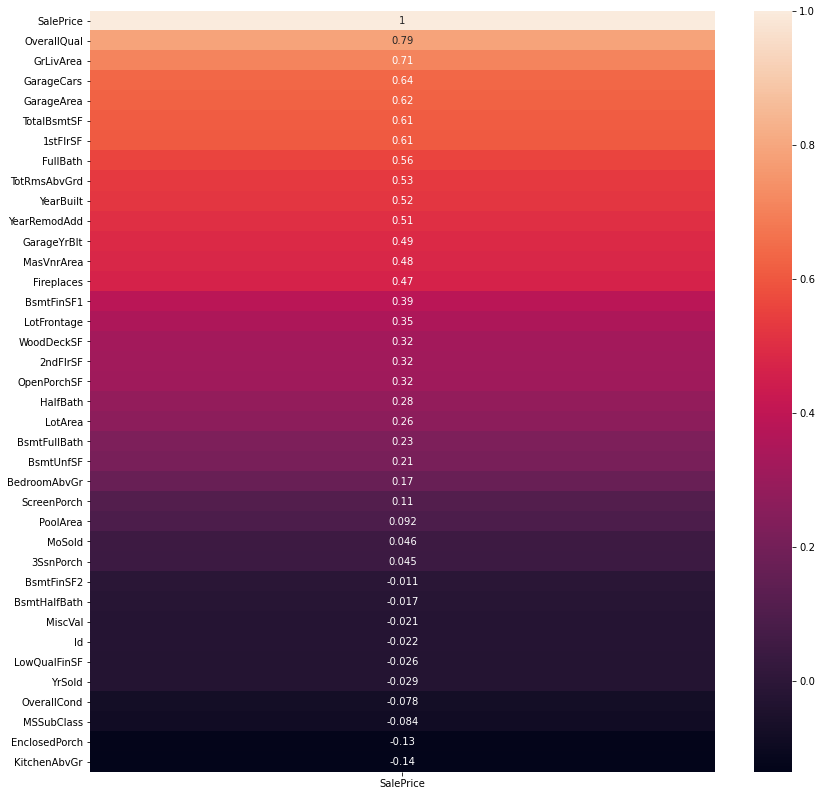

In [8]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(pd.DataFrame(corr_df['SalePrice'].sort_values(ascending=False)),
            ax=ax,
            annot=True)
plt.show()

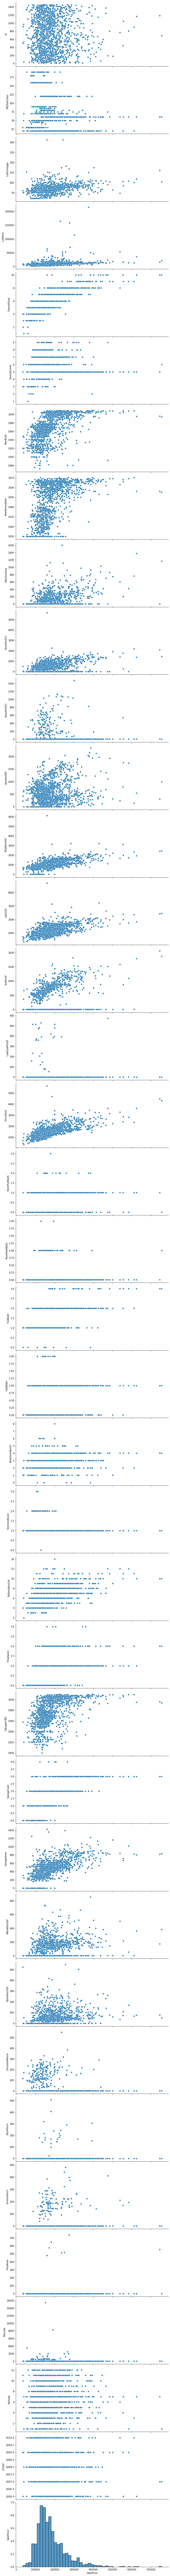

In [9]:
sns.pairplot(data=train,
             x_vars=['SalePrice'],
             height=4,
             aspect=2.5)
plt.show()

## Data Preprocessing 

### Feature Engineering 

As there are some features that in our opinion have more opinion being considered as 1 (such as the total Porch area or the total # of bathrooms in the house) we may create this features in our dataset:

In [10]:
class FeatureCreator(BaseEstimator,TransformerMixin):
    """Creates new columns based on the information present in the dataset
    """
    def __init__(self, *args, **kwargs):
        return None

    def fit(self, dataset: pd.DataFrame):
        return self
    
    def transform(self, dataset: pd.DataFrame) -> pd.DataFrame:
        X = dataset.copy()

        # Creating the new columns
        X["TotalNumBath"] = X["BsmtFullBath"] + X["BsmtHalfBath"] + X["FullBath"] + X["HalfBath"]
        X["TotalPorchSF"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]

        return X

In [11]:
feature_creator = FeatureCreator()
train = feature_creator.fit_transform(train)

### Dropping unnecesary information 

There are some variables, such as the `Id` that give us no information about the price or the reasons behind it. Therefore, we should eliminate them from our dataset in order to reduce the noise that they might cause in our target variable.

In [12]:
class ColumnDropper(BaseEstimator,TransformerMixin):
    """Drops the unnecesary columns of our dataset
    """
    columns: list
    
    def __init__(self, columns, *args, **kwargs):
        self.columns = columns
        return None

    def fit(self, dataset: pd.DataFrame):
        return self
    
    def transform(self, dataset: pd.DataFrame) -> pd.DataFrame:
        X = dataset.copy()

        # Drops the information explicited
        X = X.drop(self.columns, axis=1)
        
        return X

In [13]:
cols_to_drop = [
    "Id",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch"
]

column_dropper = ColumnDropper(columns=cols_to_drop)
train = column_dropper.fit_transform(train)

### NA Values

In [14]:
def get_pct_na_values(dataset: pd.DataFrame) -> pd.Series:
    """Get the % of NA values present in each column of the dataset
    
    :param dataset: Dataset to check NA values
    :return: Series with the % of NA values of each column
    """
    pct_na_values = (dataset.isna().sum() / dataset.shape[0]).sort_values(ascending=False)
    
    return pct_na_values

In [16]:
pct_na_values = get_pct_na_values(train)

# Showing only results with more than 5% of NA values
print(pct_na_values.loc[pct_na_values>0.05])

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageCond      0.055479
dtype: float64


#### Converting to Booleans

If we look at the top values with most NA, we clearly see that some of them could be transformed into booleans, as we may lose some information on the process but due to the small number of observations filled that information could not be infer us too much. So, lets start with `PoolQC`, `MicsFeature` and `Fence`:

In [17]:
class NAConverter(BaseEstimator, TransformerMixin):
    """Converts the NA columns specified into Boolean types
    """
    columns: list
    
    def __init__(self, columns, **kwargs):
        self.columns = columns
        return None

    def fit(self, dataset: pd.DataFrame):
        return self
    
    def transform(self, dataset: pd.DataFrame) -> pd.DataFrame:
        X = dataset.copy()

        # Converts the columns specified to booleans
        X[self.columns] = ~X[na_cols_to_convert].isna()
        
        return X

In [18]:
na_cols_to_convert = [
    "PoolQC",
    "MiscFeature",
    "Fence"
]

na_converter = NAConverter(columns=na_cols_to_convert)
train = na_converter.fit_transform(train)

#### Dropping columns with high NA values

As a second step towards NA cleaning, we may also drop the columns with high NA values which we may think that no value is provided by them, for instance the `Alley` variable:

In [19]:
na_cols_to_drop = [
    "Alley",
    "FireplaceQu",
    "LotFrontage"
]
na_column_dropper = ColumnDropper(columns=na_cols_to_drop)
train = na_column_dropper.fit_transform(train)

#### Imputation

Now, if we look at our dataset, we may appreciate that some NA values still exist:

In [21]:
pct_na_values = get_pct_na_values(train)

# Showing only results with NA values
print(pct_na_values.loc[pct_na_values>0])

GarageFinish    0.055479
GarageCond      0.055479
GarageYrBlt     0.055479
GarageQual      0.055479
GarageType      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtQual        0.025342
MasVnrType      0.005479
MasVnrArea      0.005479
Electrical      0.000685
dtype: float64


To deal with this issue, we may imputate the categorical columns with the value `UNKNOWN` and the numerical values with the mean of each column:

In [22]:
class NAImputer(BaseEstimator, TransformerMixin):
    """Imputes NA values using mean and UNKNOWN
    """
    columns: list
    
    def __init__(self, columns, *args, **kwargs):
        self.columns = columns
        return None
    
    def fit(self, dataset: pd.DataFrame):
        return self

    def transform(self, dataset: pd.DataFrame) -> pd.DataFrame:
        X = dataset.copy()
        
        # For categorical columns put UNKNOWN, for numerical the mean
        for column in self.columns:
            if X[column].dtype == object:
                X[column] = X[column].fillna("UNKNOWN")
            else:
                X[column] = X[column].fillna(value=X[column].mean())
        
        return X

In [23]:
na_cols_to_impute = [
    "GarageFinish",
    "GarageCond",
    "GarageYrBlt",
    "GarageQual",
    "GarageType",
    "BsmtFinType2",
    "BsmtExposure",
    "BsmtCond",
    "BsmtFinType1",
    "BsmtQual"
]

na_imputer = NAImputer(columns=na_cols_to_impute)
train = na_imputer.fit_transform(train)

#### Dropping rows with NAs

Finally, for the rest of the columns, we are going to simply drop the observations with NA values, as they are too few and it's the simpliest solutions in this case in order to avoid imputing too many values or desvirtue the dataset: 

In [24]:
class NARowDropper(BaseEstimator, TransformerMixin):
    """Drops the rows with NA values
    """
    def __init__(self, *args, **kwargs):
        return None
    
    def fit(self, dataset: pd.DataFrame):
        return self
    
    def transform(self, dataset: pd.DataFrame) -> pd.DataFrame:
        X = dataset.copy()
        
        X = X.dropna()
        
        return X

In [25]:
na_row_dropper = NARowDropper()
train = na_row_dropper.fit_transform(train)

### Scaling the data 

In [26]:
class ColumnScaler(BaseEstimator, TransformerMixin):
    """Scale the columns specified of our dataset
    """
    columns: list

    def __init__(self, columns: list, *args, **kwargs):
        self.columns = columns
    
    def fit(self, dataset: pd.DataFrame):
        return self

    def transform(self, dataset: pd.DataFrame) -> pd.DataFrame:
        X = dataset.copy()
        
        sc = StandardScaler()
        X[self.columns] = sc.fit_transform(X[self.columns])

        return X

In [27]:
num_columns = list(train.columns[
    (train.dtypes != object) & (train.columns != "SalePrice")
])

column_scaler = ColumnScaler(columns=num_columns)
train = column_scaler.fit_transform(train)

### Encoding

As a final step in our preprocessing task, we may now need to encode all our categorical values into binary columns, in order to make them easy to deal by our models.

In [28]:
class ColumnEncoder(BaseEstimator,TransformerMixin):
    """Encode our categorical columns into dummy ones
    """
    columns: list
    
    def __init__(self, columns: list, *args, **kwargs):
        self.columns = columns
    
    def fit(self, dataset: pd.DataFrame):
        return self
    
    def transform(self, dataset: pd.DataFrame):
        X = dataset.copy()

        # Creation of Dummy columns
        enc = pd.get_dummies(X[self.columns], drop_first=True)
        # Joining them with our DataFrame
        X = pd.concat([X, enc], axis=1)
        # Dropping the old columns
        X = X.drop(self.columns, axis=1)

        return X

In [30]:
cat_columns = list(train.columns[train.dtypes == object])

column_encoder = ColumnEncoder(columns=cat_columns)
train = column_encoder.fit_transform(train)

## Modelling

On the field of Machine Learning, there are several approaches to consider. Some of the most used ones are quite old (as Linear Regression or Decision Trees) but its efficiency makes them stand among the most used techniques even nowadays. On the other hand, there are some algorithms that became popular more recently, such as Support Vector Machines or Extreme Gradient Boosting, due to their capabilities while facing complicated non linear problems.

I will use some of these algorithms in order to get a grasp at what makes house prices vary, and at the same time I hope I'll provide a useful demonstration between the approaches of these different methods.

### Dividing the Data 

In [31]:
X_train = train.drop('SalePrice', axis=1)
y_train = train.SalePrice

### Regularized Linear Regression

In [39]:
param_lasso = {
    "alpha": [0.001, 0.01, 0.1, 0.5, 1, 10]
}

lasso_grid = GridSearchCV(
    Lasso(tol=0.1), param_grid=param_lasso, scoring='neg_root_mean_squared_error', cv=10
)
lasso_grid.fit(X_train, y_train)
lasso_model = lasso_grid.best_estimator_

print(f"Best estimator generated: {lasso_model}")

lasso_rmse = np.mean(cross_val_score(
    lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=20
))

print(f"Precision expected of the Lasso model: {lasso_rmse}")

Best estimator generated: Lasso(alpha=0.5, tol=0.1)
Precision expected of the Lasso model: -36743.39115436807


### Support Vector Machines

In [43]:
param_svm = {
    "kernel": ["rbf", "linear"],
    "C": [10, 100, 500, 1000, 5000]
}

svm_grid = GridSearchCV(
    SVR(), param_grid=param_svm, scoring='neg_root_mean_squared_error', cv=10
)
svm_grid.fit(X_train, y_train)
svm_model = svm_grid.best_estimator_

print(f"Best estimator generated: {svm_model}")

svm_rmse = np.mean(cross_val_score(
    svm_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=20
))

print(f"Precision expected of the SVM model: {svm_rmse}")

Best estimator generated: SVR(C=5000, kernel='linear')
Precision expected of the SVM model: -27525.752682101564


### Decision Trees

In [47]:
param_tree = {
    "max_depth": [10, 25, 50, 100],
    "min_samples_split": [10, 25, 50, 100],
}

tree_grid = GridSearchCV(
    DecisionTreeRegressor(), param_grid=param_tree, scoring='neg_root_mean_squared_error', cv=10
)
tree_grid.fit(X_train, y_train)
tree_model = tree_grid.best_estimator_

print(f"Best estimator generated: {tree_model}")

tree_rmse = np.mean(cross_val_score(
    tree_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=20
))

print(f"Precision expected of the Decision Trees model: {tree_rmse}")

Best estimator generated: DecisionTreeRegressor(max_depth=10, min_samples_split=25)
Precision expected of the Decision Trees model: -35918.384204362505


### Random Forests

In [49]:
param_forest = {
    "max_depth": [10, 50, 100, 200],
    "n_estimators": [10, 50, 100, 200, 300]
}

forest_grid = GridSearchCV(
    RandomForestRegressor(n_jobs=8), param_grid=param_forest, scoring='neg_root_mean_squared_error', cv=5
)
forest_grid.fit(X_train, y_train)
forest_model = forest_grid.best_estimator_

print(f"Best estimator generated: {forest_model}")

forest_rmse = np.mean(cross_val_score(
    forest_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10
))

print(f"Precision expected of the Random Forest model: {forest_rmse}")

Best estimator generated: RandomForestRegressor(max_depth=100, n_estimators=300, n_jobs=8)
Precision expected of the Random Forest model: -27525.752682101564


### Extreme Gradient Boosting

In [ ]:
# xgboost

### Deep Learning

In [ ]:
# keras